## 06. PyTorch Transfer Learning

- https://www.learnpytorch.io/06_pytorch_transfer_learning/

Where to find pretrained models

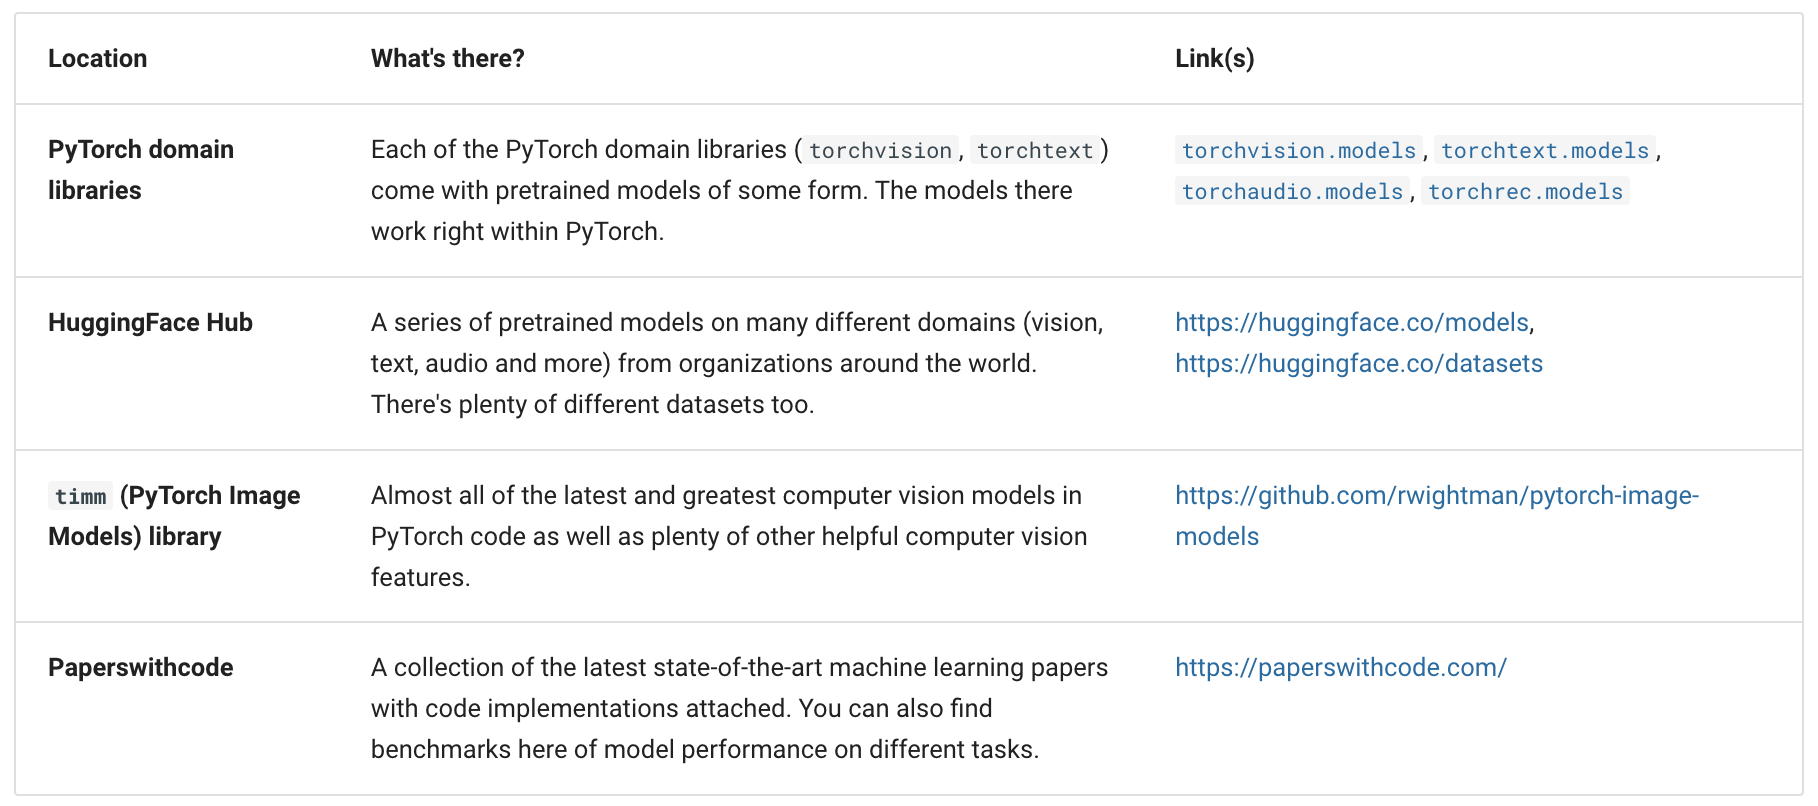

### 0. Getting setup

In [1]:
# try:
#     import torch
#     import torchvision
#     assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
#     assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")
# except:
#     print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
#     !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
#     import torch
#     import torchvision
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 MB 17.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.5 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 26.8 MB/s eta 0:00:0031m30.0 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.0
    Uninstalling torchvision-0.15.0:
      Successfully uninstalled torchvision-0.15.0
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.0
    Uninstalling torchaudio-2.0.0:
      Successfully uninstalled torchaudio-2.0.0
torch version: 2.0.0
torchvision version: 0.1

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [2]:
import sys
import os

In [3]:
sys.path

['/Users/sguys99/Desktop/project/pytorch-study/zero-to-mastery',
 '/Users/sguys99/opt/anaconda3/envs/torch/lib/python39.zip',
 '/Users/sguys99/opt/anaconda3/envs/torch/lib/python3.9',
 '/Users/sguys99/opt/anaconda3/envs/torch/lib/python3.9/lib-dynload',
 '',
 '/Users/sguys99/opt/anaconda3/envs/torch/lib/python3.9/site-packages']

In [4]:
sys.path.append('/Users/sguys99/Desktop/project/pytorch-study/zero-to-mastery/05.Going_Modular/')

In [5]:
sys.path

['/Users/sguys99/Desktop/project/pytorch-study/zero-to-mastery',
 '/Users/sguys99/opt/anaconda3/envs/torch/lib/python39.zip',
 '/Users/sguys99/opt/anaconda3/envs/torch/lib/python3.9',
 '/Users/sguys99/opt/anaconda3/envs/torch/lib/python3.9/lib-dynload',
 '',
 '/Users/sguys99/opt/anaconda3/envs/torch/lib/python3.9/site-packages',
 '/Users/sguys99/Desktop/project/pytorch-study/zero-to-mastery/05.Going_Modular/']

In [6]:
from going_modular import data_setup, engine

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1. Get data

In [8]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [9]:
train_dir = image_path / "train"
test_dir = image_path / "test"

### 2. Create Datasets and DataLoaders

- 데이터 로딩을 위해 data_setup.py를 사용하면 된다.  
- 그런데 여기서는 전이학습 모델을 사용하기 때문에 특별한 transform 작업이 필요하다.

Creating a transform for torchvision.models (manual creation)

- 토치비전 v0.13 이상 버전부터 torchvision.models를 사용하여 데이터 트랜스폼을 생성하는 방법에 대한 업데이트가 이루어졌습니다. 
- 이전 방법을 '수동 생성'이라고 부르고 새로운 방법을 '자동 생성'이라고 부릅니다. 이 노트북은 두 가지 방법을 모두 보여줍니다.

전이학습 모델을 사용할 때, 모델에 들어가는 커스텀 데이터가 모델에 들어간 원래 학습 데이터와 동일한 방식으로 준비되는 것이 중요합니다.

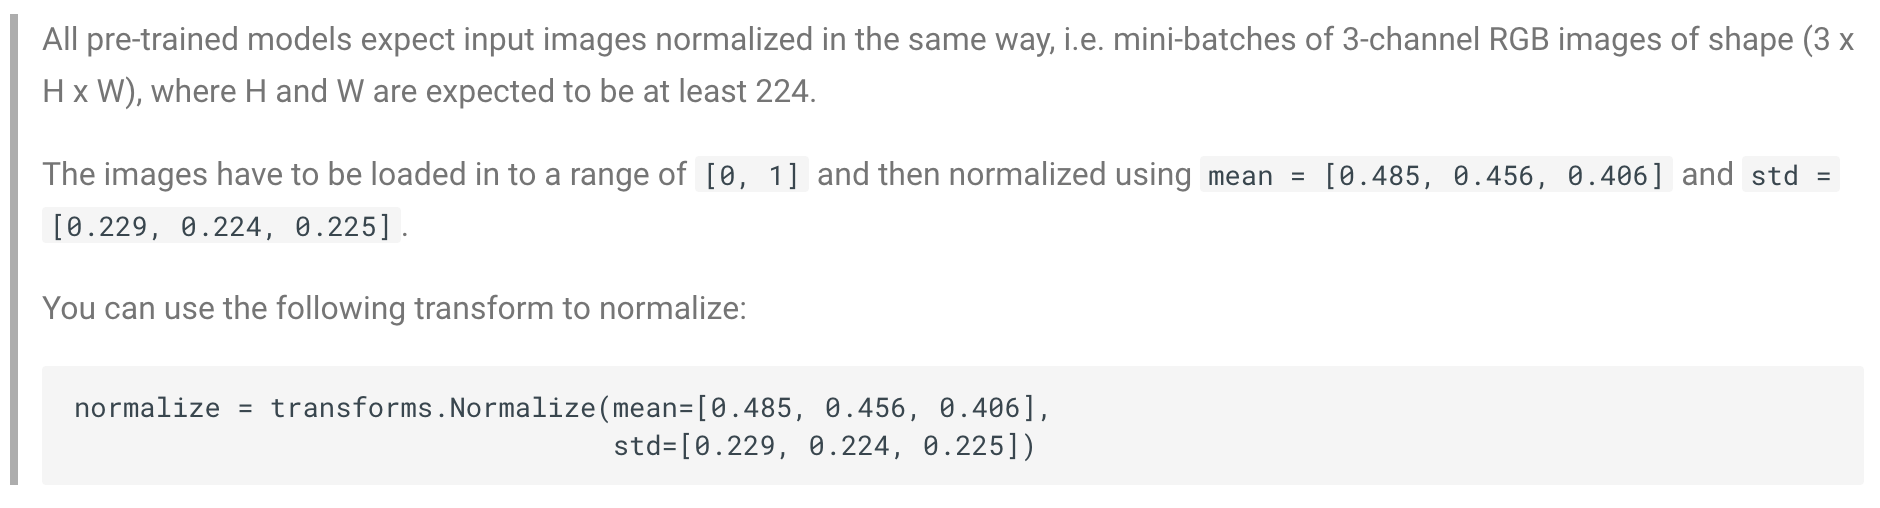

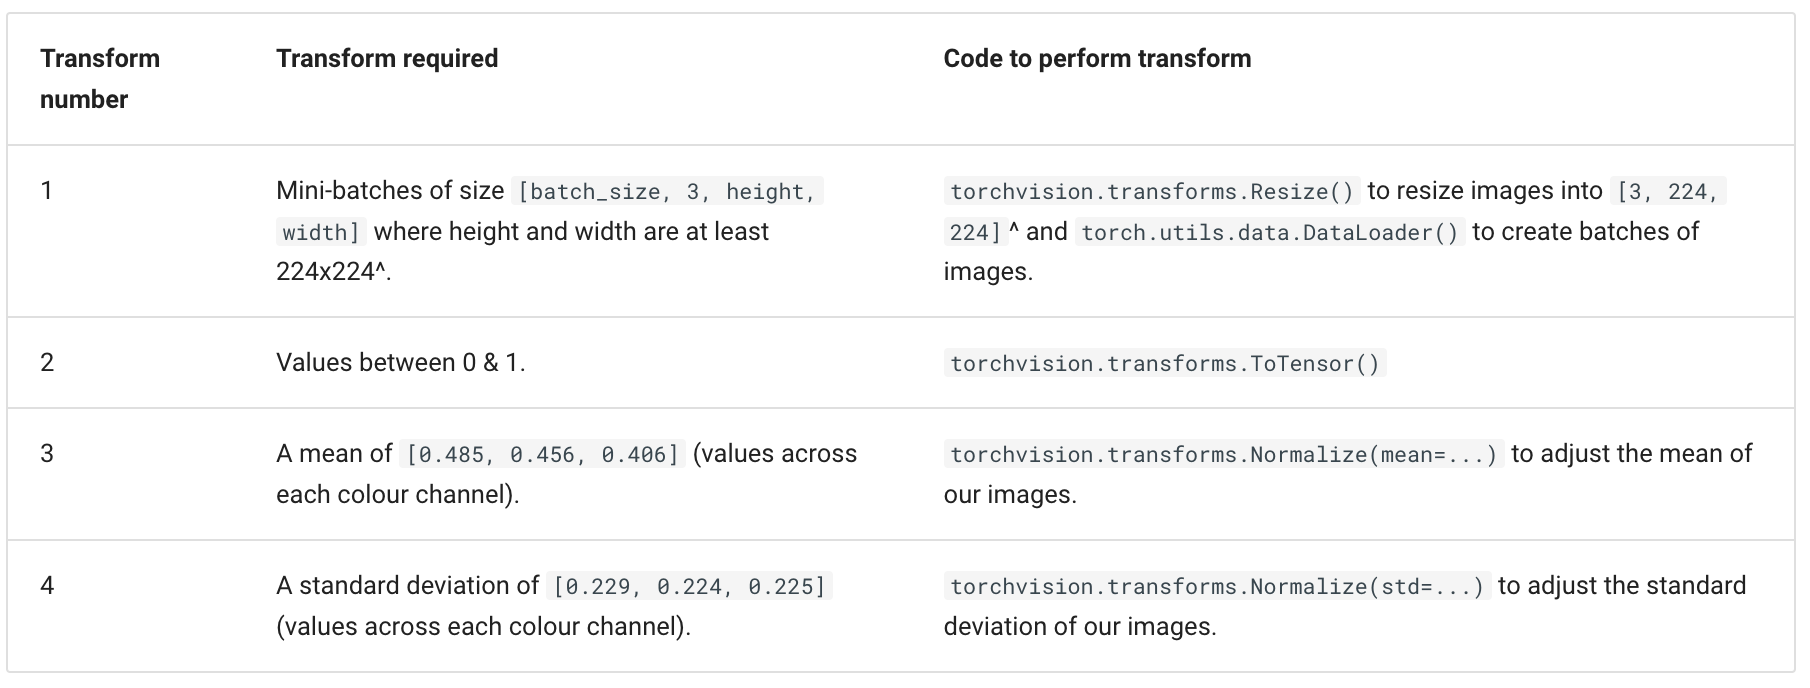

torchvision.models의 어던 모델들은 [3, 224, 224] 사이즈와 다를 수도 있어 어떤 것은 [3, 240, 240]인 것들도 있다. 따라서 다큐먼트의 이미지 사이즈를 잘 봐야 한다.

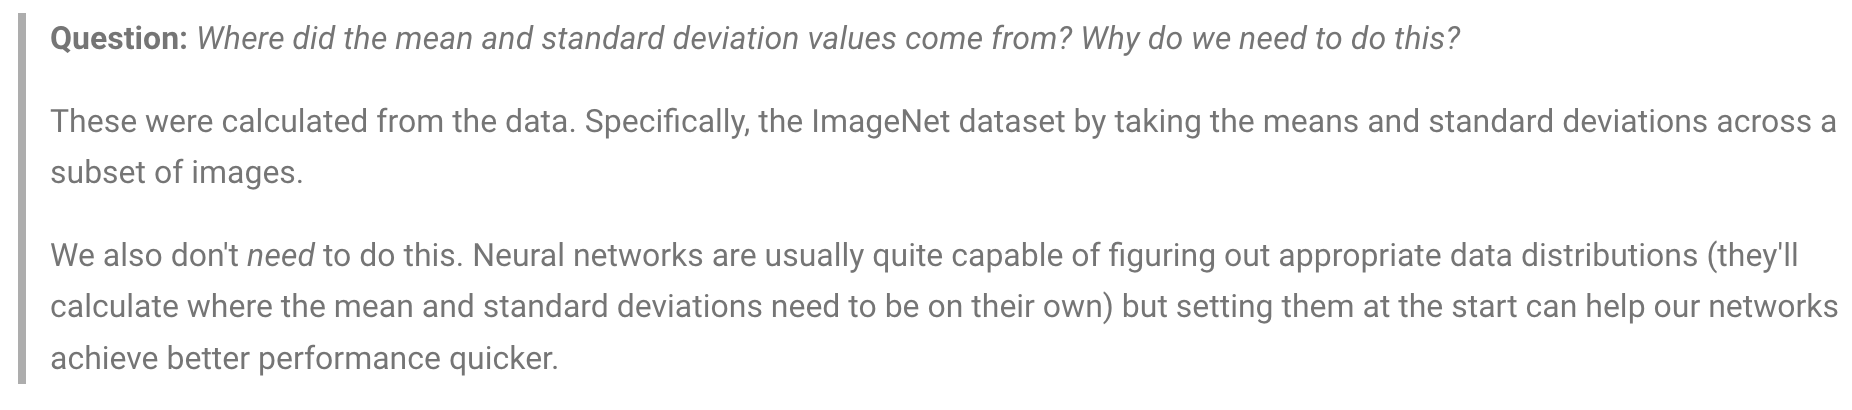

이제 트랜스폼을 만들어보자.

In [10]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

 data_setup.py 에 있는 create_dataloader 함수를 호출할 떄 이 것을 사용하면 된다.

In [11]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=manual_transforms,
                                                                              batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1065d1fa0>,
 ['pizza', 'steak', 'sushi'])

Creating a transform for torchvision.models (auto creation)

앞에서 우리는 수동으로 전이학습 모델에 주입될 데이터 transform 하는 방법을 배웠다.  

그러나 토치비전 0.13 이후에 automatic transform 생성 기능이 생겼다.

예를 들어 사용한 전이학습 모델의 가중치를 선택한 후  

```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
```



여기서   
- EfficientNet_B0_Weights : 사용할 모델 아키텍처  
- DEFAULT : 가장 적절한 것... (예를 들어 이미지넷에서 성능이 가장 우수한것)  
    - 모델을 선택하면 IMAGENET_V1 and IMAGENET_V2처럼 선택할 수도 있는다. 일반적으로 높은 버전이 성능이 좋다. 가장 좋은것을 원한다면 DEFAULT를 선택하는 것이 좋다.

In [12]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [13]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x10647d6d0>,
 ['pizza', 'steak', 'sushi'])

### 3. Getting a pretrained model

전이학습 모델들은 torchvision.models에서 찾을 수 있다.

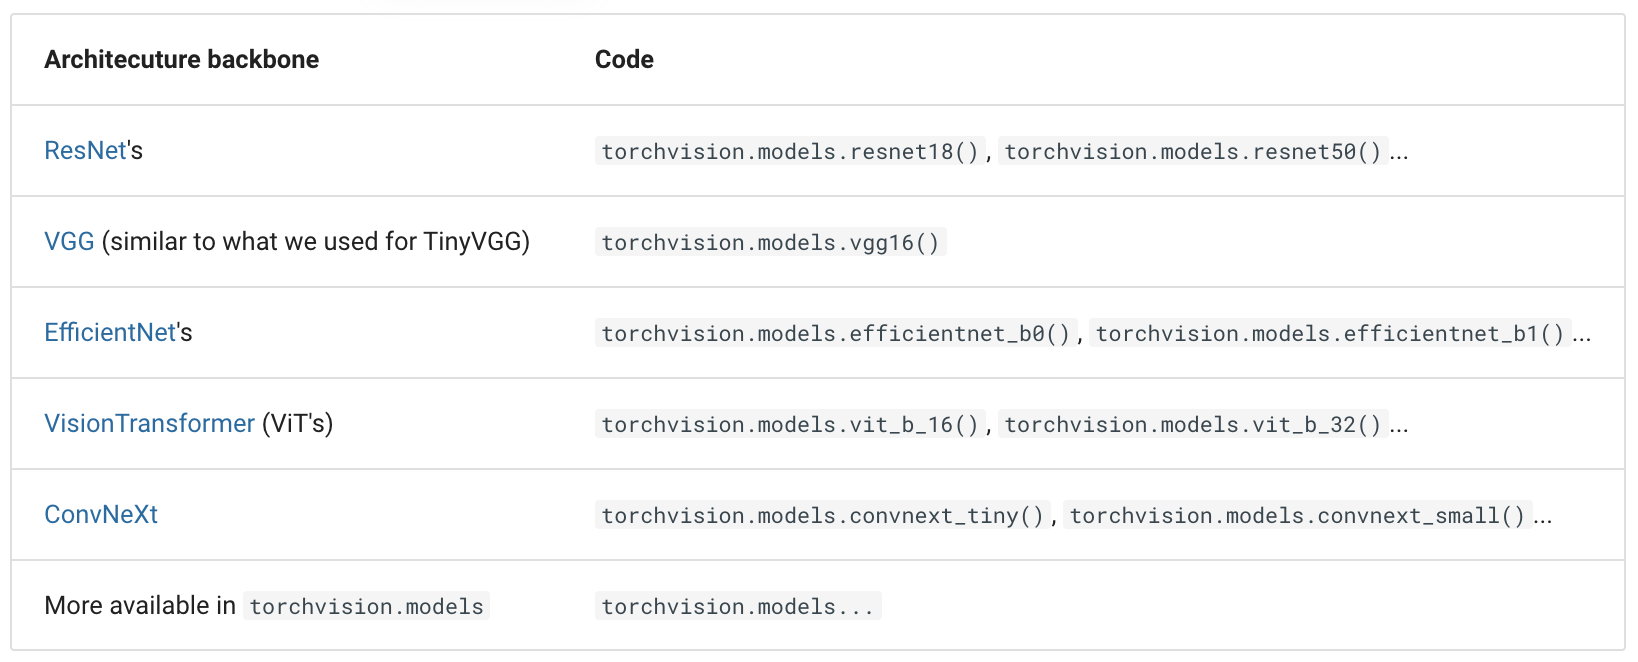

어떤 모델을 선택할까

Generally, the higher number in the model name (e.g. efficientnet_b0() -> efficientnet_b1() -> efficientnet_b7()) means better performance but a larger model.   

- some better performing models are too big for some devices.

- performance vs. speed vs. size tradeoff

Setting up a pretrained model

여기서는 torchvision.models.efficientnet_b0()를 사용

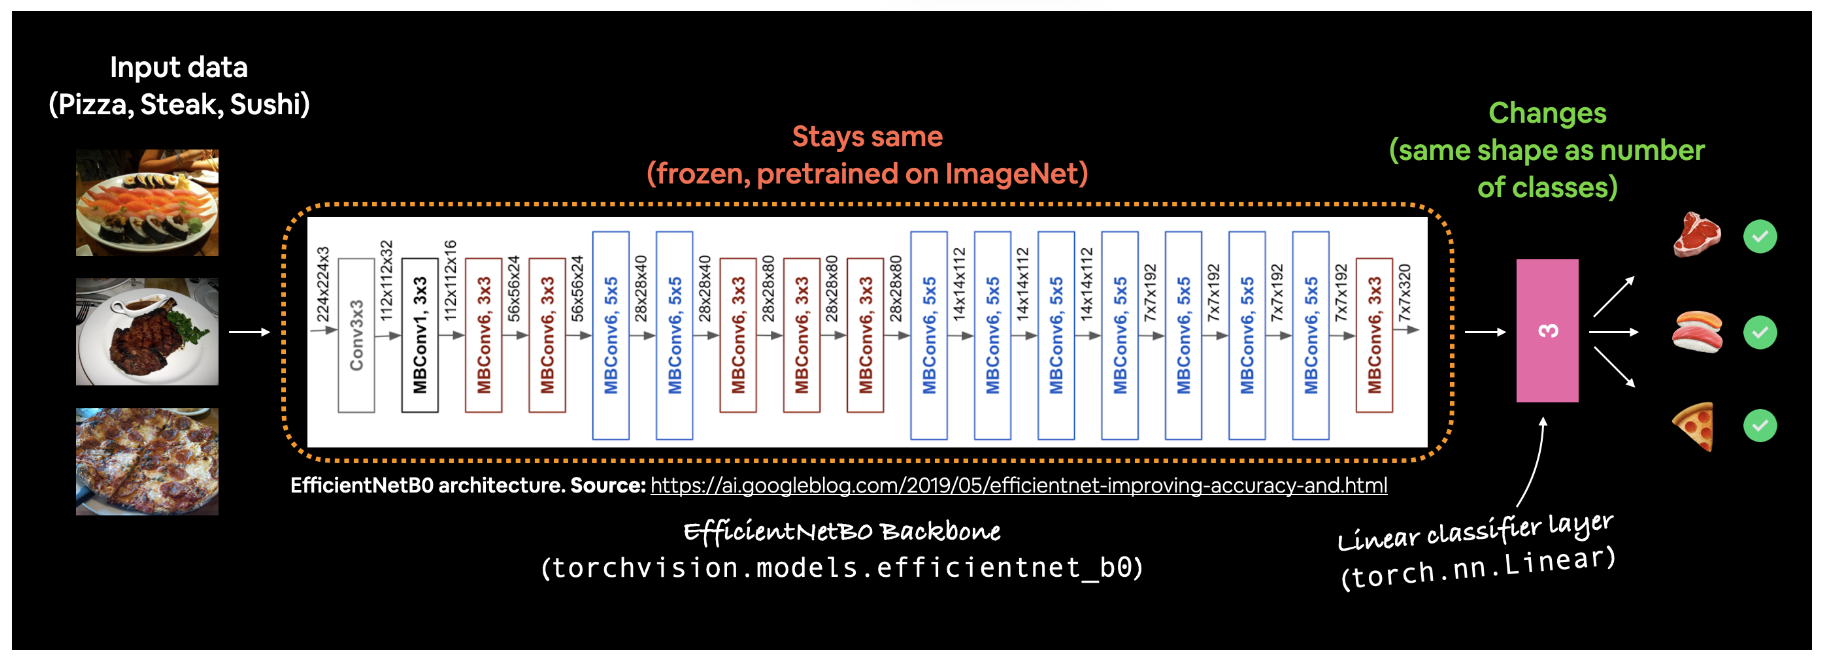

앞에 만든 weights 변수를 활용하여 모델을 만들 수 있다...

In [15]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

In [16]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [17]:
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [18]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

- **중요** UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.

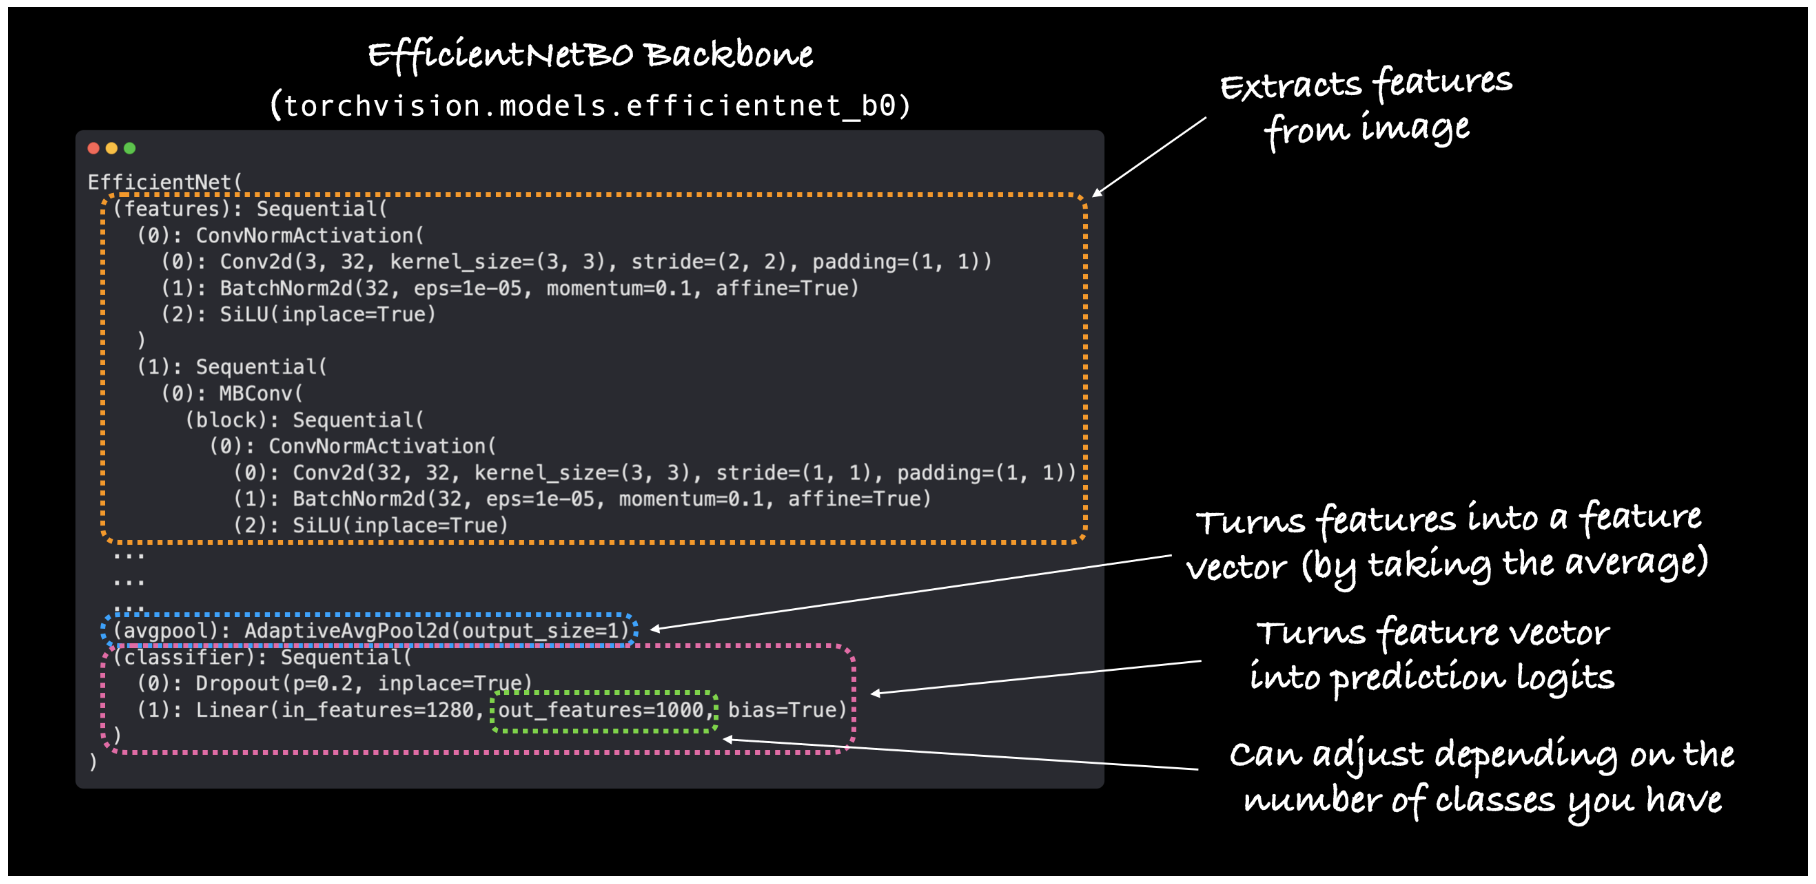

efficientnet_b0는 세가지 파트로 되어있다.  
- features 또는 feature extractor : 컨볼루션 레이어들  
- avgpool : 컨벌루션 레이어의 출력에 평균을 취해서 feature vector로 만드는 부분
- classifier : feature vector를 출력 클래스 수와 같은 dimension으로 만드는 부분(여기의 경우 out_feature=1000)이다

Getting a summary of our model with torchinfo.summary()

- model : 요약대상
- input_size : 입력할 데이터 shape
- col_names : 모델에서 확인할 정보
- col_width : how wide the columns should be for the summary.
- row_settings - what features to show in a row.

**중요** Note: Many modern models can handle input images of varying sizes thanks to torch.nn.AdaptiveAvgPool2d(), this layer adaptively adjusts the output_size of a given input as required. You can try this out by passing different size input images to summary() or your models.

In [19]:
summary(model= model,
       input_size = (32, 3, 224, 224), # input shape가 아니라 input size임에 유의
       # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

/Users/sguys99/opt/anaconda3/envs/torch/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

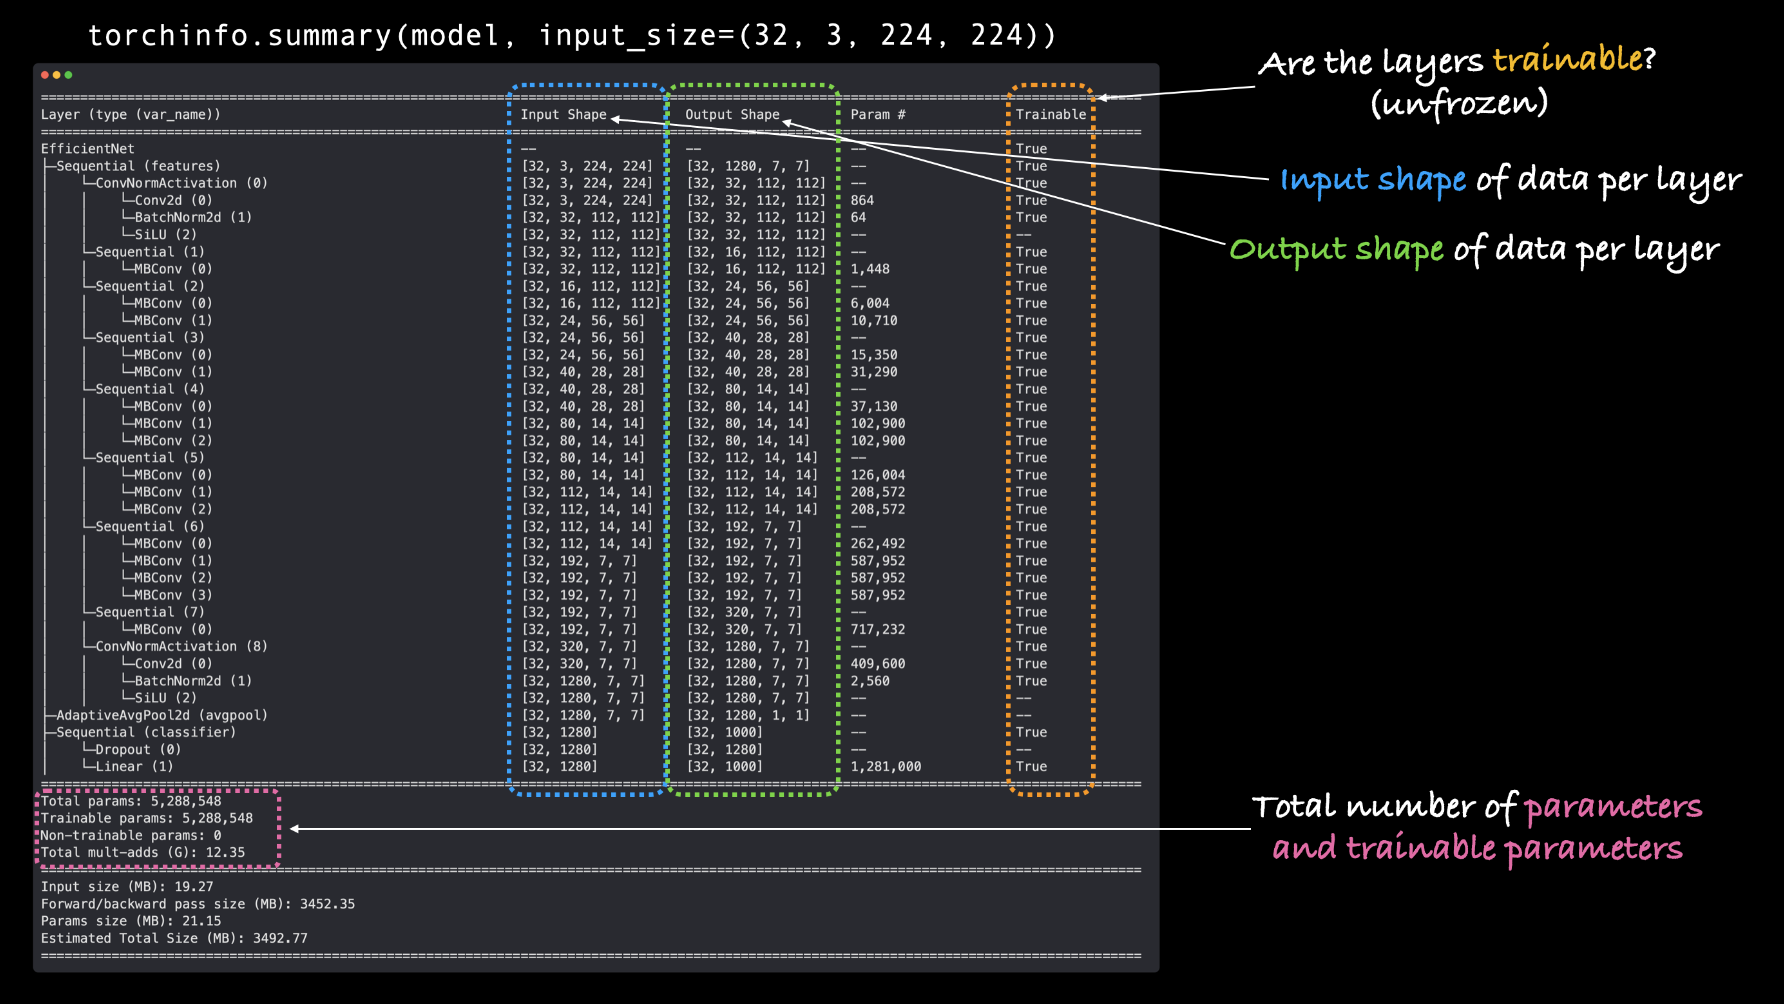

- TinyVGG had 8,083 parameters vs. 5,288,548 parameters for efficientnet_b0, an increase of ~654x!

Freezing the base model and changing the output layer to suit our needs

In [20]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

이제 features 부분을 프리징 시켜보자. reauires_grad = False로 지정하면된다.

In [21]:
for params in model.features.parameters():
    params.requires_grad = False

현재 classifier 부분은 다음과 같다.

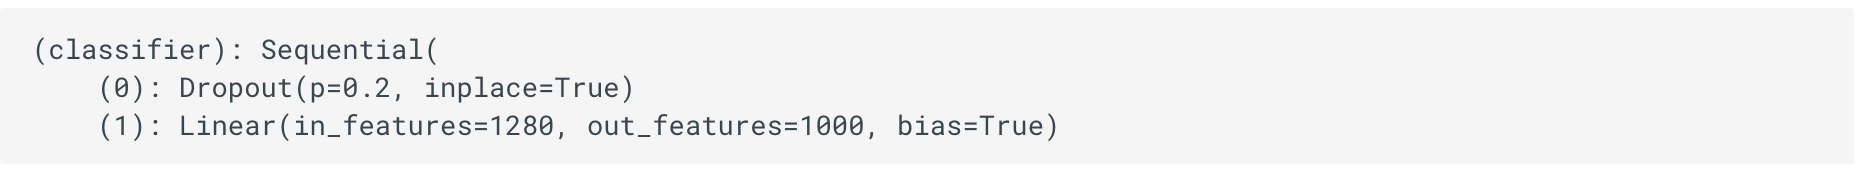

3개 클래스로 바꿔본다.

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace=True),
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape,
                   bias=True)).to(device)

In [23]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [24]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

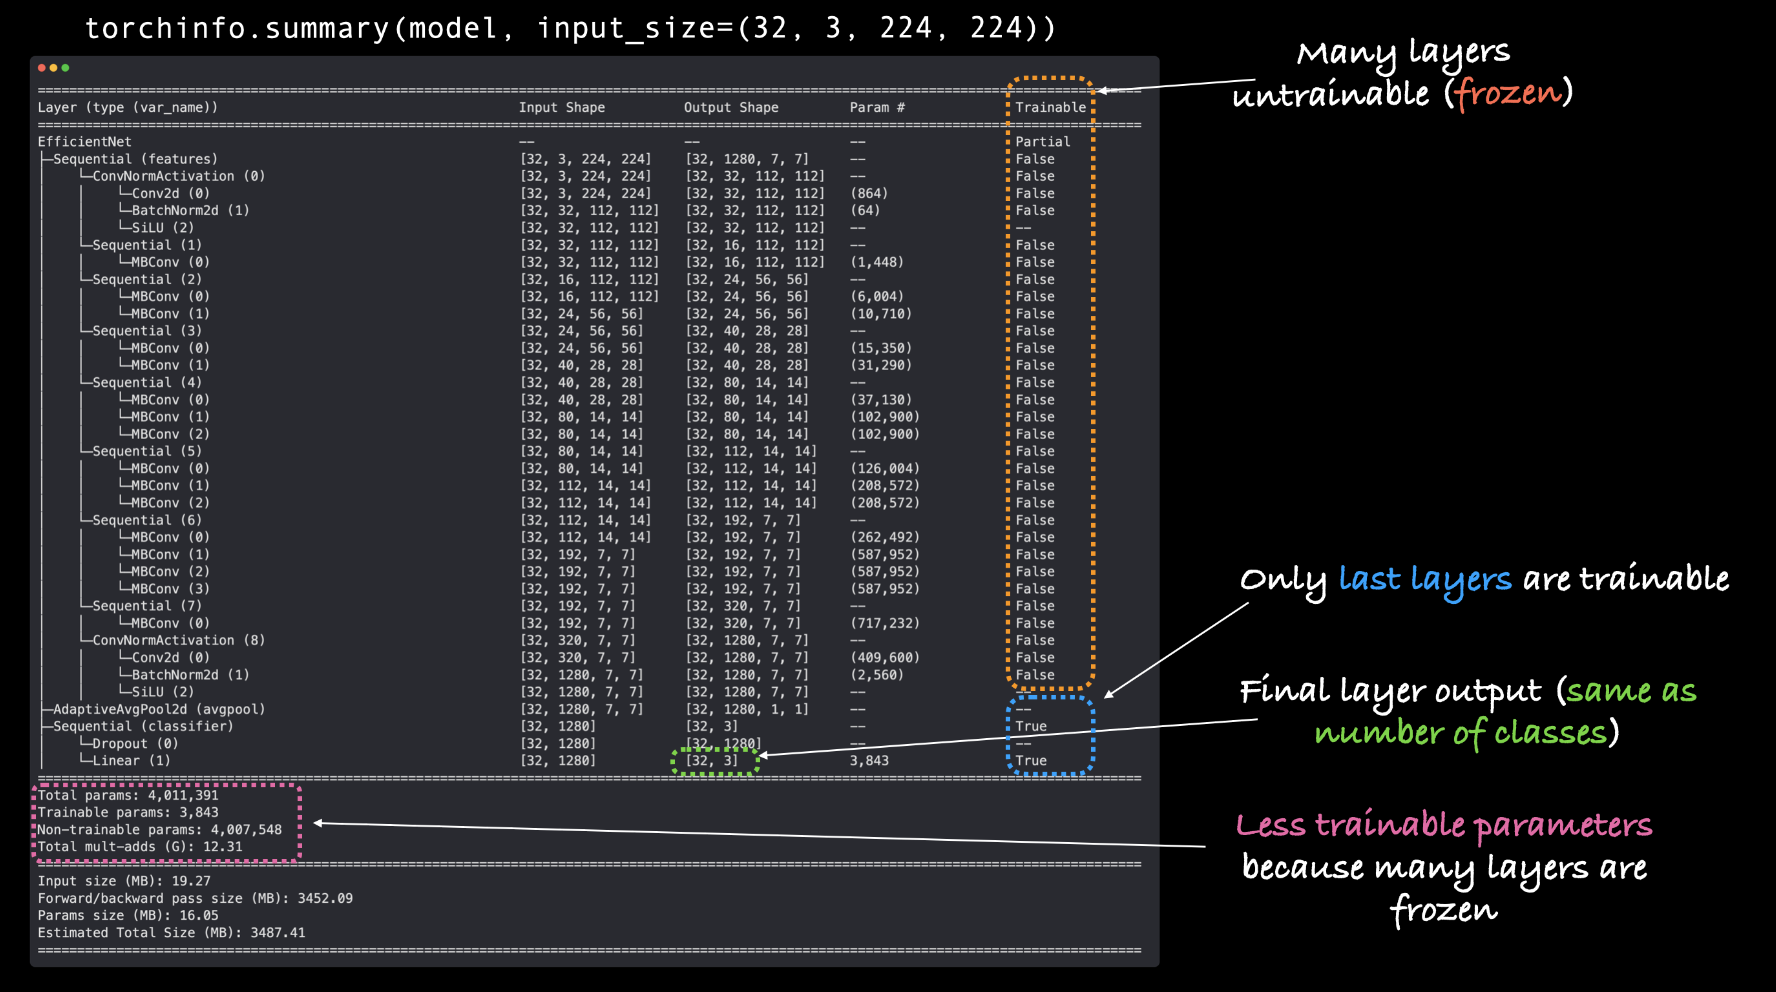

바뀐 부분  
- Trainable column   
- Output shape : 32, 1000 -> 32, 3  
- Less trainable parameters 

### 4. Train model

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [26]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0901 | train_acc: 0.4102 | test_loss: 0.8925 | test_acc: 0.6714
Epoch: 2 | train_loss: 0.9162 | train_acc: 0.6367 | test_loss: 0.8032 | test_acc: 0.7746
Epoch: 3 | train_loss: 0.8170 | train_acc: 0.7070 | test_loss: 0.6780 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7456 | train_acc: 0.7266 | test_loss: 0.6718 | test_acc: 0.8248
Epoch: 5 | train_loss: 0.6219 | train_acc: 0.7656 | test_loss: 0.6246 | test_acc: 0.8561
[INFO] Total training time: 127.106 seconds


### 5. Evaluate model by plotting loss curves

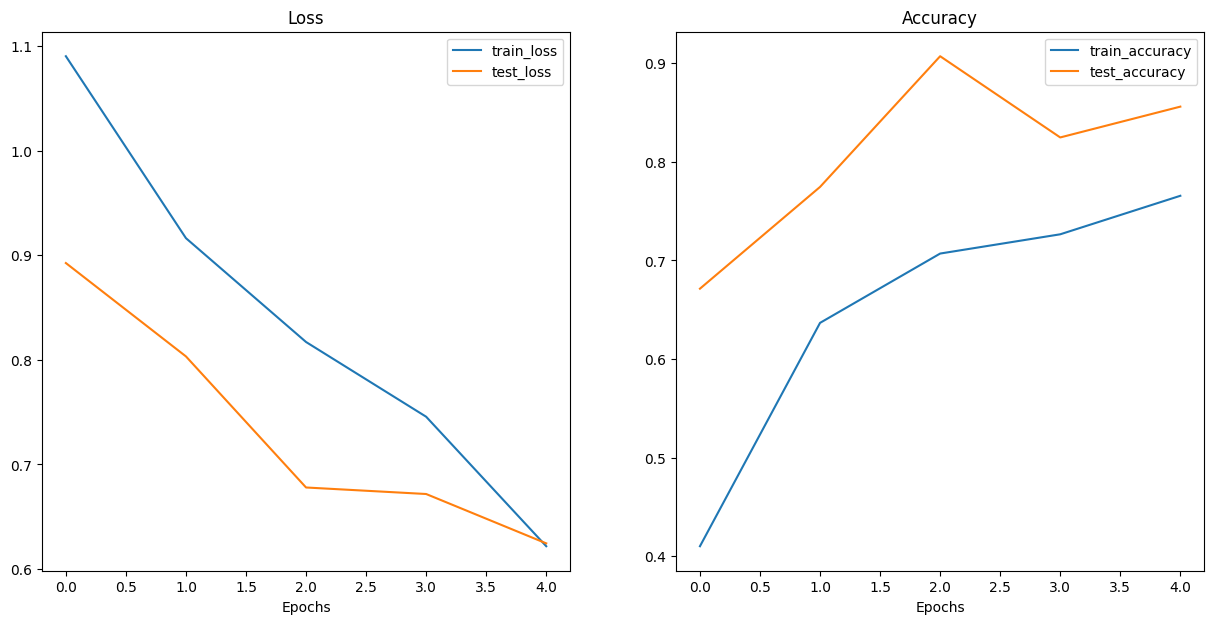

In [27]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)


### 6. Make predictions on images from the test set

정량적으로는 모델이 잘 작동하는 것 같지만 정성적으로는 어떨까?  
테스트 세트의 이미지(훈련 중에는 볼 수 없음)에 대해 모델을 사용하여 몇 가지 예측을 하고 이를 플로팅해보자.  

한 가지 기억해야 할 점은 모델이 이미지를 예측하려면 모델이 학습한 이미지와 동일한 형식의 이미지여야 한다는 것입니다.

따라서 다음이 동일해야한다.   
- Same shape : shape가 다르면 에러발생
- Same datatype : 데이터 타입이 다르면 (e.g. torch.int8 vs. torch.float32) 에러발생
- Same device : 이미지와 모델의 device가 다르면 에러발생
- Same transformations - 학습에서의 transformation과 다르면 예측이 안될 것이다.

이를 위해 pred_and_plot_image()라는 함수를 만들자.

- 모델, 클래스 이름, 이미지 경로, 이미지크기, transform,device 등을 받는다.  
- Open an image with PIL.Image.open()
- 이미지에 대한 트랜스폼을 생성합니다(manual_transforms이나 weights.transforms()에서 생성된 것 사용)
- 모델이 타겟 디바이스에 있는지 확인
- model.eval()로 모델 평가 모드를 켭니다(이렇게 하면 nn.Dropout()과 같은 레이어가 꺼지므로 추론에 사용되지 않음).
- 3단계에서 만든 transform으로 대상 이미지를 변형하고 torch.unsqueeze(dim=0)로 배치 치수를 추가하여 입력 이미지의 모양이 [batch_size, color_channels, height, width]가 되도록 합니다.
이미지가 대상 디바이스에 있는지 확인하여 모델에 전달하여 이미지를 예측.

- torch.softmax()를 사용하여 모델의 출력 로그를 예측 확률로 변환합니다.
- torch.argmax()를 사용하여 모델의 예측 확률을 예측 레이블로 변환합니다.
- matplotlib로 이미지를 플롯하고 제목을 9단계의 예측 레이블로, 예측 확률을 8단계의 예측 확률로 설정합니다.

In [28]:
from typing import List, Tuple
from PIL import Image

In [29]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    # 2. Open image
    img = Image.open(image_path)
    
    # 3. Create transformation for image  (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        
    # 4. make sure the model is one the target device
    model.to(device)
    
    # 5. turn on model evaluation mode and infrerence mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim = 0)
        
        # 7. 예측
        target_image_pred = model(transformed_image.to(device))
        
        #8.
        target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)
        
        #9.
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)
        
        # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

- 참고 : https://yeko90.tistory.com/entry/pytorch-modeleval-vs-torchnograd

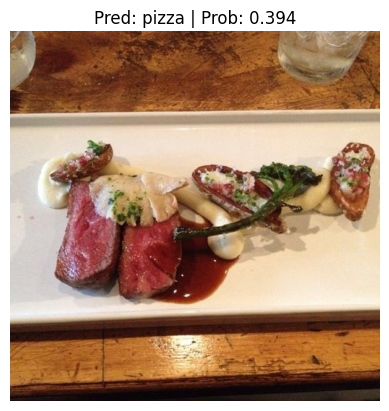

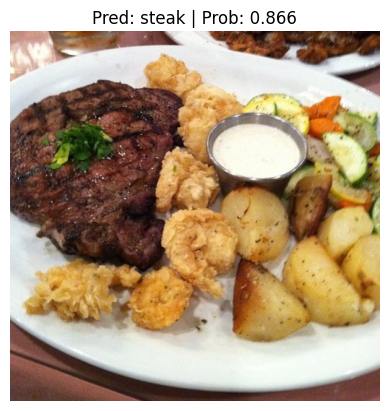

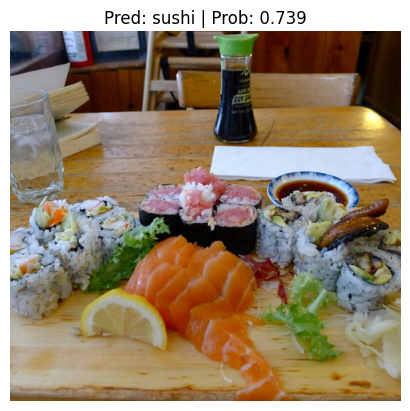

In [30]:
import random

num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

Making predictions on a custom image

data/04-pizza-dad.jpeg already exists, skipping download.


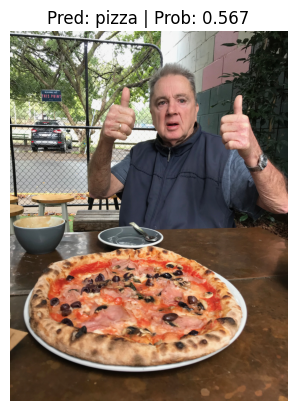

In [31]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

**중요**
- All exercises should be completed using device-agnostic code.
- 참고 : https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code